In [1]:
from skimage.filters import gaussian 
from skimage.color import rgb2hsv, hsv2rgb
import cv2 as cv
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import numpy as np
import sys
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split


In [2]:
import pandas as pd
train_labels = pd.read_csv('../data/train_labels.csv')
train_features = pd.read_csv('../data/train_features.csv')

train_merged = pd.merge(train_labels, train_features, on='id')
train_merged_back = train_merged.copy()

#print(train_merged.head())

In [3]:
unique_sites = train_merged['site'].unique()

temp_df = train_merged.groupby("site").sum()
temp_df.drop("id", axis=1, inplace=True)
temp_df.drop("filepath", axis=1, inplace=True)
#print(temp_df)
total_sightings = temp_df.iloc[:, 1:].sum(axis=1).tolist()

unique_sites = pd.DataFrame({"site": unique_sites, "total_sightings": total_sightings})

unique_sites = unique_sites.sort_values(by="total_sightings", ascending=False)

#for site in unique_sites['site']:
#    print(f'"{site}",', end='')




In [4]:
def get_data(sites):
    processing = train_merged_back.loc[train_merged_back['site'].isin(sites)]
    print(processing.shape)
    labels = processing.drop(['filepath', 'id', 'site'], axis=1)
    images = []

    for index, row in processing.iterrows():  
        image_path = row['filepath']
        image = cv.imread(os.path.join('../data/', image_path))
        image = cv.resize(image, (960, 540))

        images.append(image)

    images = np.array(images)
    return images, labels

In [5]:
bla = unique_sites["site"].iloc[:10]
test1, test2 = get_data(bla)
#print(test2.head())
print(test2.shape)

(943, 11)
(943, 8)


In [6]:
def train_model(images, label):
    model = keras.Sequential([
    Flatten(input_shape=(960, 540, 3)),
    Dense(8, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(images, label, epochs=2, batch_size = 32)
    return model

In [7]:
model = train_model(test1, test2)
test3, test4 = get_data(["S0076","S0110","S0083","S0047"])

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.1735 - loss: 183819.3906
Epoch 2/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3332 - loss: 39699.8281
(374, 11)


In [8]:
def print_accuracy(model, images, labels):
    loss, acc = model.evaluate(images, labels)
    print(f"Model loss: {loss}, Model accuracy: {acc}")


In [9]:
print_accuracy(model, test3, test4)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4364 - loss: 58217.0977
Model loss: 60978.04296875, Model accuracy: 0.44117647409439087


In [10]:
bla = unique_sites["site"].iloc[:10]
test1, test2 = get_data(bla)

(943, 11)


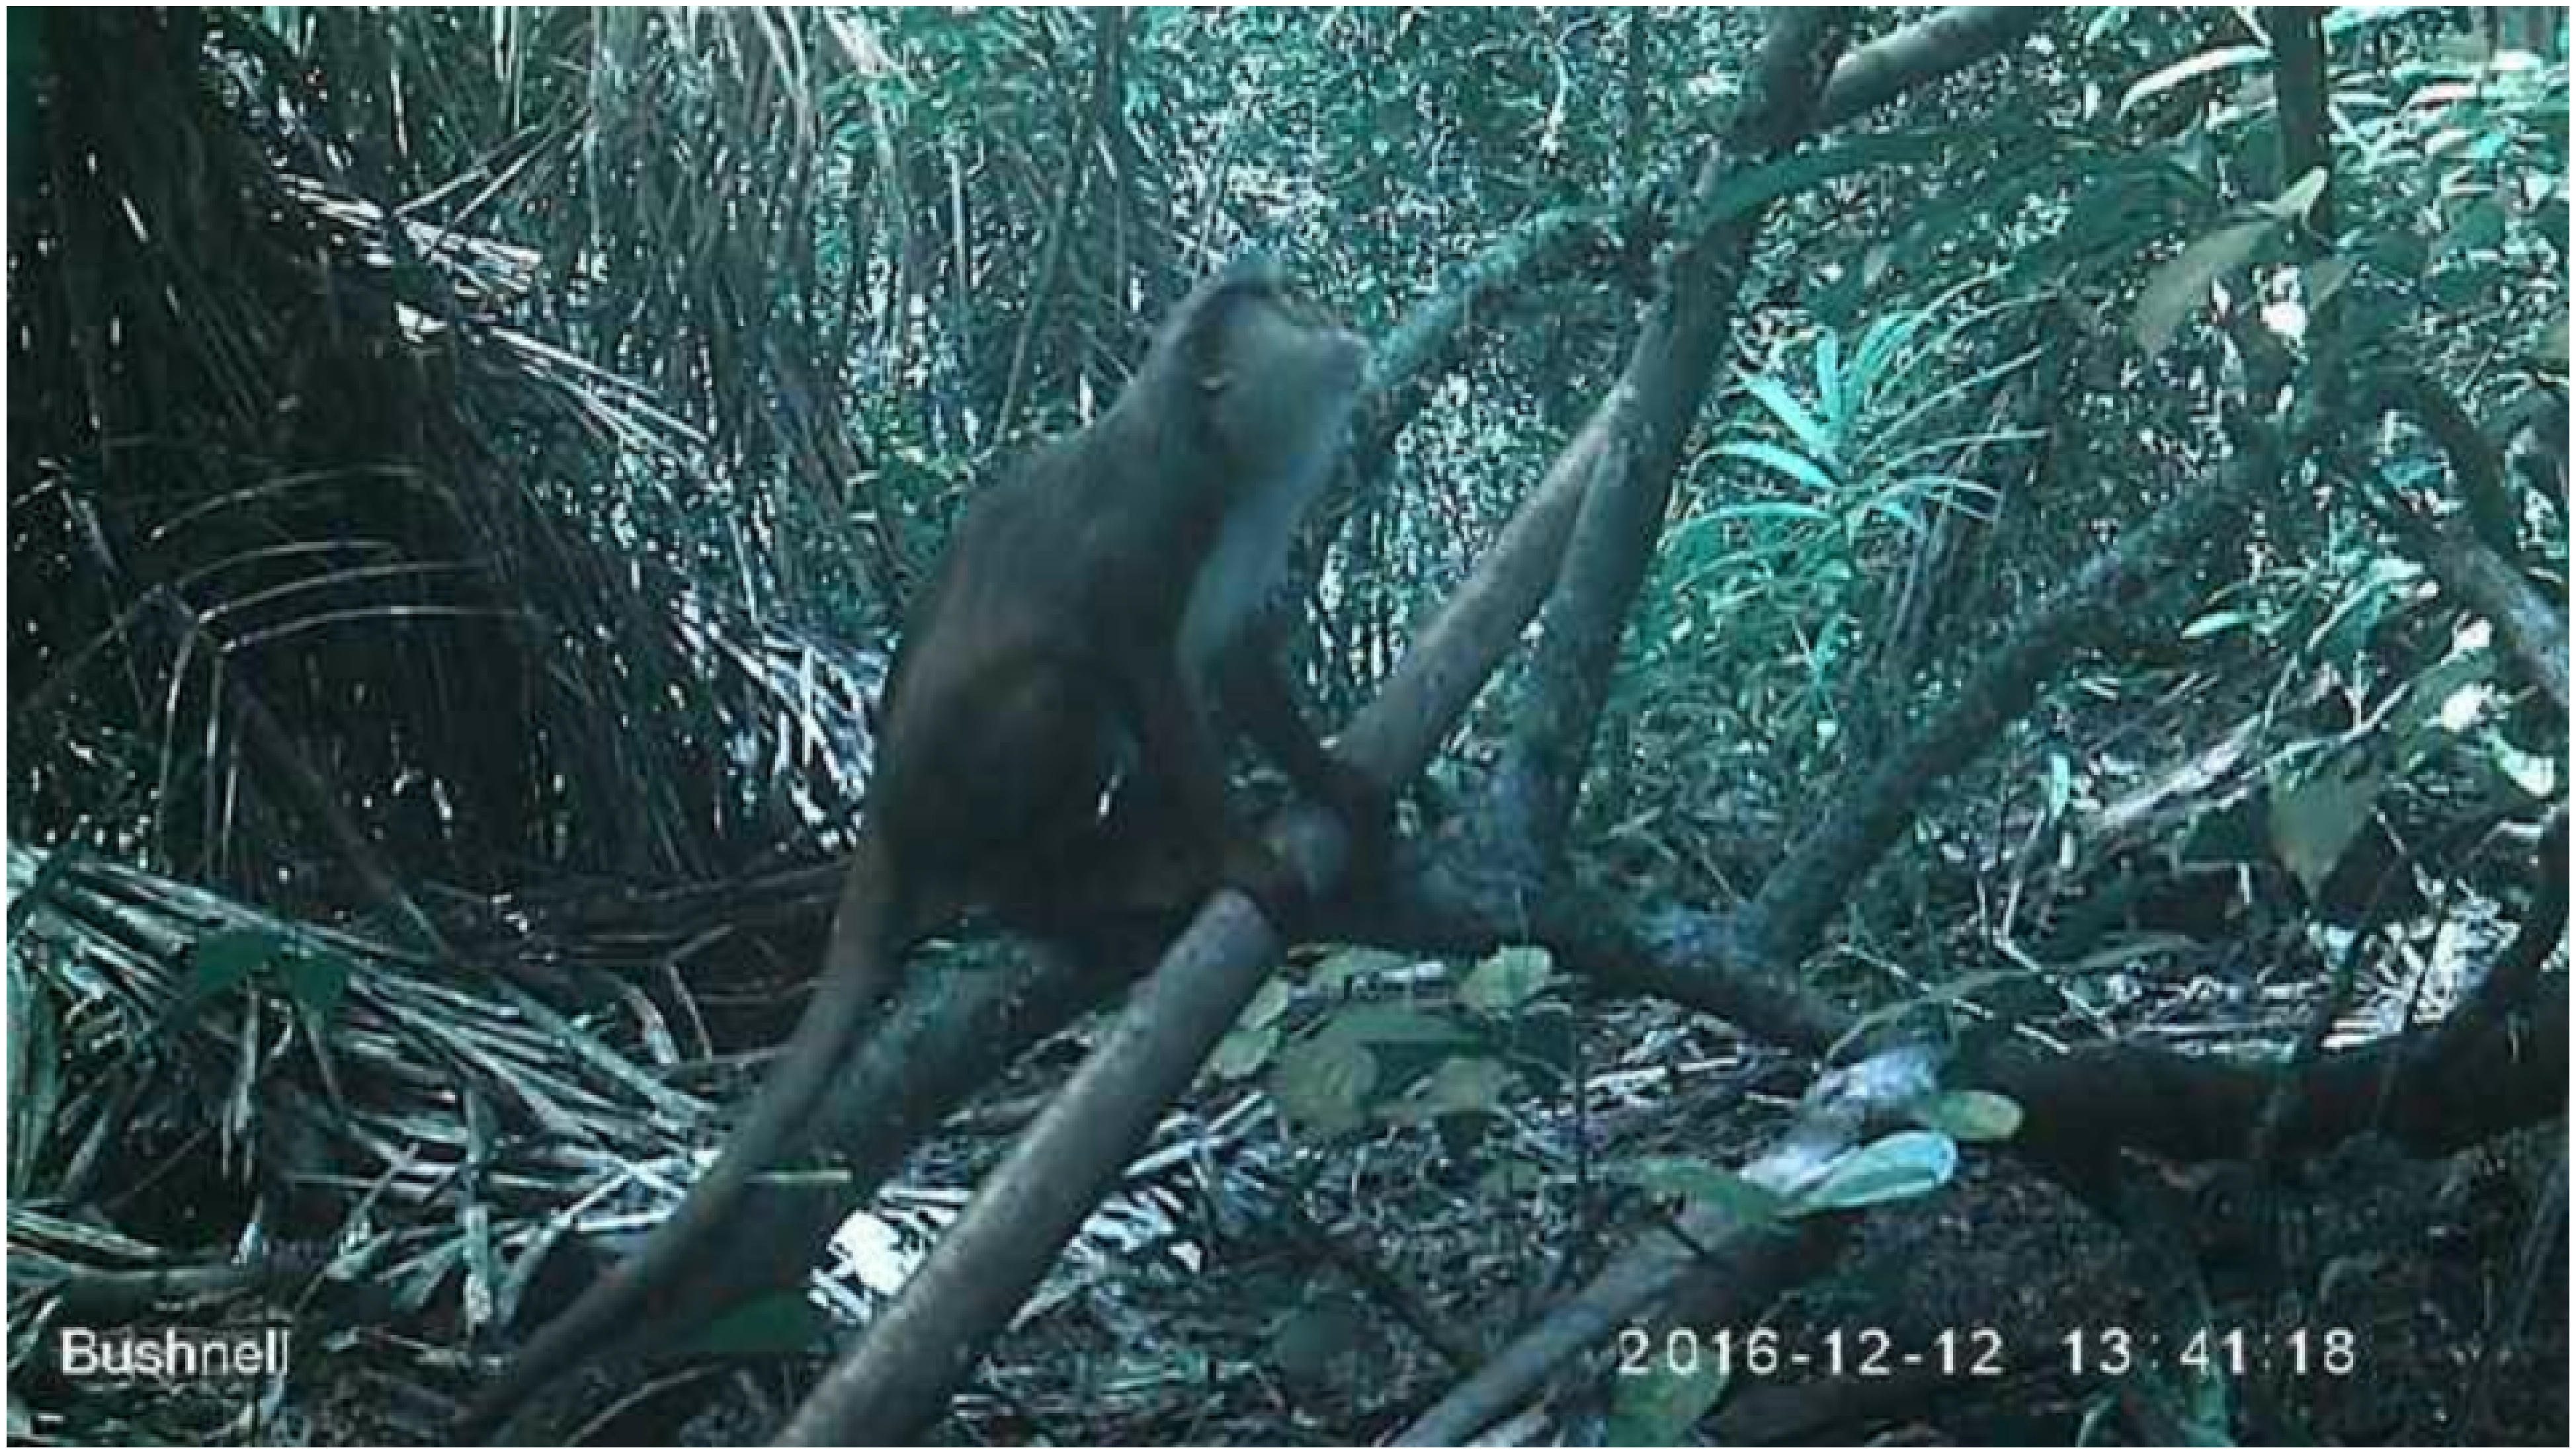

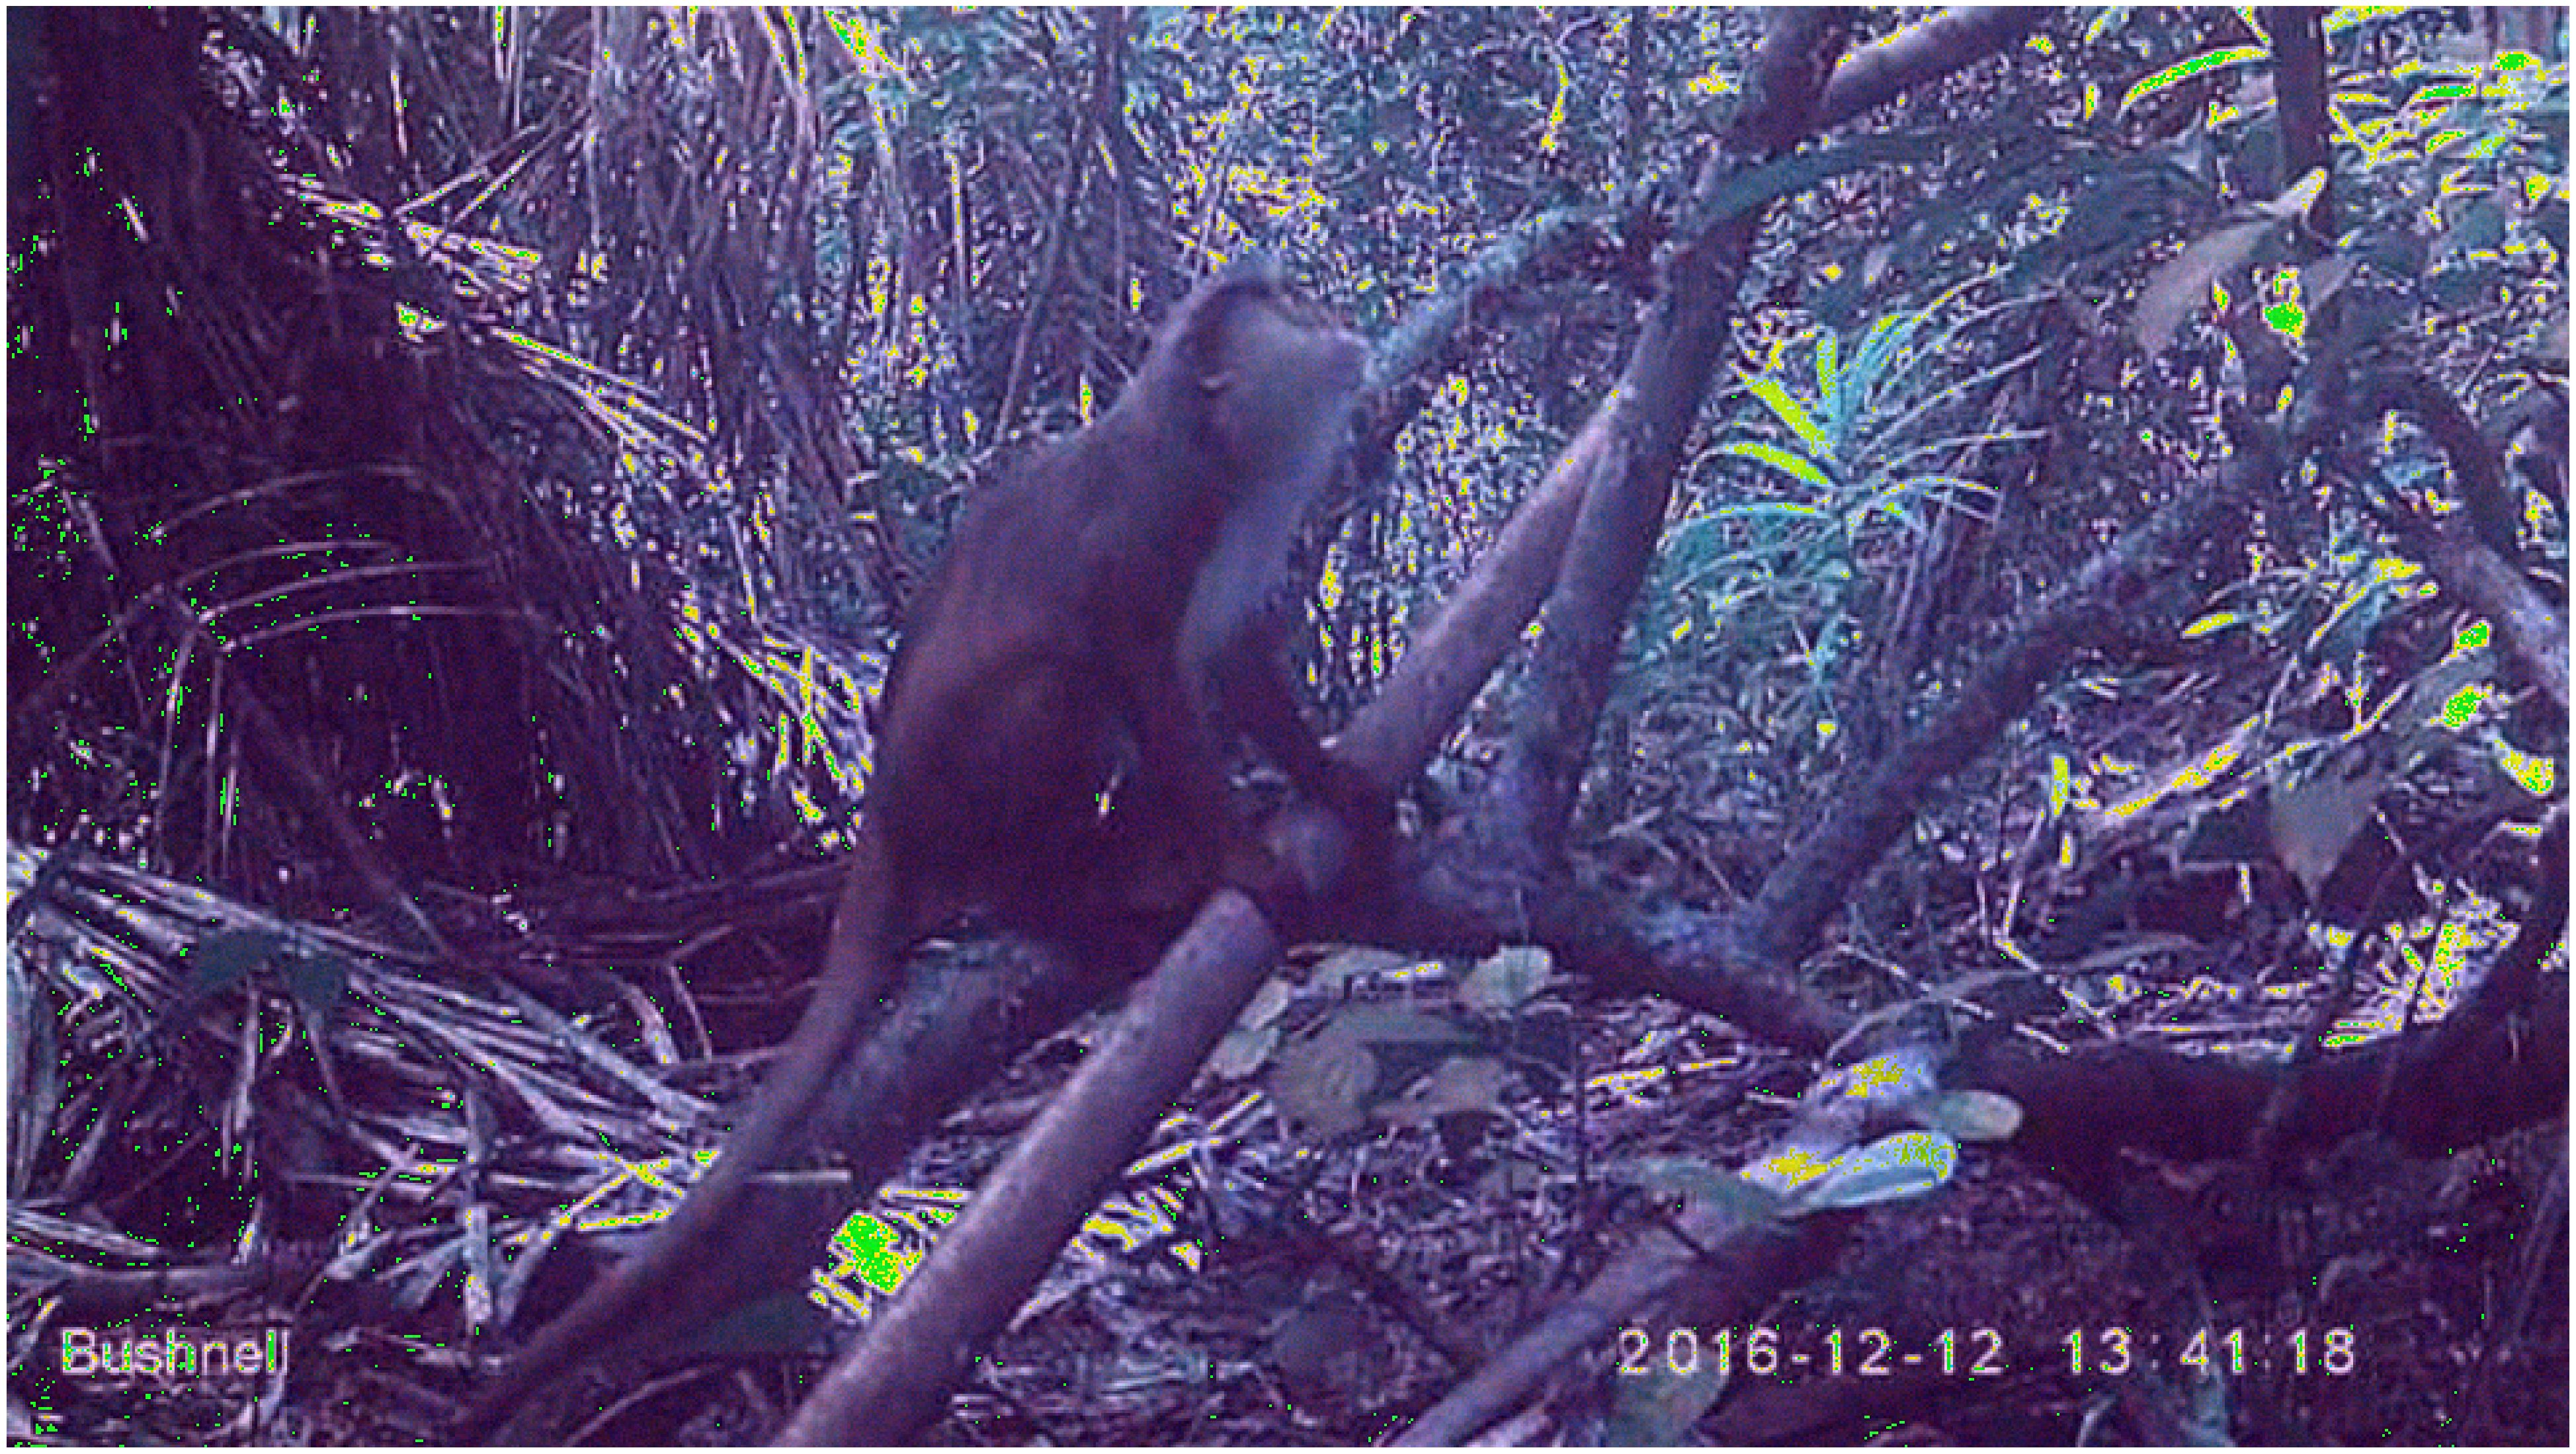

In [11]:
#concatt = [test2, test2]
#test2 = pd.concat(concatt)
#test1 = np.concatenate((test1, np.flip(test1, axis=2)))
#print(test2.shape)
#print(test1.shape)
np.random.seed(42)
image = test1[4] 
hsv_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
h, w, c = hsv_image.shape

noise_red = np.random.randint(10, 50, size=image.shape[:2])
noise_green = np.random.randint(-20, -10, size=image.shape[:2])
noise_blue = np.random.randint(10, 50, size=image.shape[:2])
fig, axes = plt.subplots(nrows = 1, figsize =(50, 50))
axes.imshow(image)
axes.axis("off")

#image2 = gaussian(image, sigma=1.5)
#fig, axes = plt.subplots(nrows = 1, figsize =(50, 50))
#axes.imshow(image2)
#axes.axis("off")

image3 = image.copy()
image3[:,:,0] += noise_red.astype(np.uint8)
image3[:,:,1] += noise_green.astype(np.uint8)
image3[:,:,2] += noise_blue.astype(np.uint8)
image3 = np.clip(image3, 0, 255)
fig, axes = plt.subplots(nrows=1, figsize=(50, 50))
axes.imshow(image3)
axes.axis("off")
plt.show()


In [12]:
def create_model():
    model = keras.Sequential([
    Flatten(input_shape=(960, 540, 3)),
    Dense(8, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

import random
tf.random.set_seed(42)
random.seed(42)

In [13]:
def test_aug(model, images, labels, test_images, test_labels):
    #fit
    epochs_num = 20
    batch_size_num = 32
    #gauss
    gaus_sigma_value = 1.5

    model = create_model()
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss default: {loss}, Model accuracy default: {acc}")
    del model

    model = create_model()
    images_flipped = np.flip(images, axis=2)
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(images_flipped, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss +flipped: {loss}, Model accuracy +flipped: {acc}")
    del model

    model = create_model()
    gaussed = []
    for image in images:
        gaussed.append(gaussian(image, sigma=gaus_sigma_value).astype(np.uint8))
    gaussed = np.array(gaussed)
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(gaussed, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss +gauss: {loss}, Model accuracy +gauss: {acc}")
    del model

    model = create_model()
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(images_flipped, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(gaussed, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss +flipped+gauss: {loss}, Model accuracy +flipped+gauss: {acc}")

    model = create_model()
    jittered = []
    for image in images:
        noise_red = np.random.randint(10, 50, size=image.shape[:2])
        noise_green = np.random.randint(-20, -10, size=image.shape[:2])
        noise_blue = np.random.randint(10, 50, size=image.shape[:2])
        jit_im = image.copy()
        jit_im[:,:,0] += noise_red.astype(np.uint8)
        jit_im[:,:,1] += noise_green.astype(np.uint8)
        jit_im[:,:,2] += noise_blue.astype(np.uint8)
        jit_im = np.clip(image3, 0, 255)
        jittered.append(jit_im)
    jittered = np.array(jittered)
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(jittered, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss +jitter: {loss}, Model accuracy +jitter: {acc}")
    del model

    model = create_model()
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(images_flipped, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(jittered, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss +flipped+jitter: {loss}, Model accuracy +flipped+jitter: {acc}")
    del model

    model = create_model()
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(gaussed, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(jittered, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss +gauss+jitter: {loss}, Model accuracy +gauss+jitter: {acc}")
    del model

    model = create_model()
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(images_flipped, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(gaussed, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(jittered, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss +flipped+gauss+jitter: {loss}, Model accuracy +flipped+gauss+jitter: {acc}")
    del model
    

    

In [14]:
bla = unique_sites["site"].iloc[:10]
train_img, train_lbl = get_data(bla)

bla = unique_sites["site"].iloc[-10:]
test_img, test_lbl = get_data(bla)

model = create_model()

test_aug(model, train_img, train_lbl, test_img, test_lbl)



(943, 11)
(598, 11)


/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.1716 - loss: 177193.7500
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.2608 - loss: 88751.3281
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.4148 - loss: 38785.4961
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4594 - loss: 22603.7266
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6357 - loss: 13518.0273
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5507 - loss: 28203.3711
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5199 - loss: 29236.4609
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6161 - loss: 24061.1562
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6121 - loss: 17357.9160
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5999 - loss: 22787.5000
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6481 - loss: 19881.7891
Epoch 12/20
30/30 

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.1711 - loss: 242638.4844
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.3338 - loss: 53516.0508
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.4328 - loss: 30768.3379
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.4376 - loss: 43950.7070
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5157 - loss: 34794.1016
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6582 - loss: 16136.8311
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6096 - loss: 21687.9570
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6237 - loss: 23525.1445
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6039 - loss: 25025.7461
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6069 - loss: 22427.0352
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5464 - loss: 28199.1426
Epoch 12/20
30/30

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.1764 - loss: 249124.7812
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2501 - loss: 82035.5859
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5214 - loss: 27763.1660
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5635 - loss: 28951.5547
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5279 - loss: 24170.3633
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5776 - loss: 34680.9570
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6057 - loss: 18650.1523
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7031 - loss: 12658.6475
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5184 - loss: 46228.6094
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6158 - loss: 23713.9707
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6215 - loss: 28234.5195
Epoch 12/20
30/30

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.1504 - loss: 260073.8438
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.3836 - loss: 68149.1719
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.4372 - loss: 27965.8672
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5377 - loss: 19743.8750
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6007 - loss: 17001.5918
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5410 - loss: 17520.4375
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6767 - loss: 12343.6309
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6514 - loss: 21778.9609
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6097 - loss: 21227.8789
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6525 - loss: 25559.1211
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6943 - loss: 13350.6133
Epoch 12/20
30/30 

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.1834 - loss: 212090.6406
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.2851 - loss: 101659.4219
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.4976 - loss: 24848.6973
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.4535 - loss: 29555.8105
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.5803 - loss: 15186.0098
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.5538 - loss: 28937.1328
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6543 - loss: 18911.8496
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6827 - loss: 13477.8506
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5835 - loss: 26153.2207
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.7140 - loss: 14239.9229
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5821 - loss: 24821.3477
Epoch 12/20
30/30

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.1498 - loss: 266351.8125
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.2686 - loss: 105313.5859
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.4517 - loss: 28124.0605
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.5302 - loss: 25135.5781
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.5971 - loss: 20382.5410
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5496 - loss: 20726.0508
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6619 - loss: 17133.8145
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5407 - loss: 30776.2207
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5870 - loss: 19598.2598
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6598 - loss: 18542.4023
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6622 - loss: 17983.5371
Epoch 12/20
30/30

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.1439 - loss: 175410.2656
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.3660 - loss: 62345.0586
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.4917 - loss: 30222.3633
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6195 - loss: 13097.9229
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.4594 - loss: 37907.4258
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.6282 - loss: 17587.6953
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.6677 - loss: 11739.7100
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.6604 - loss: 16179.5703
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6191 - loss: 24452.0977
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5388 - loss: 36036.1406
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.6335 - loss: 28305.0938
Epoch 12/20
30/30 

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.1629 - loss: 155375.5625
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.3141 - loss: 56460.7266
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.4634 - loss: 25992.7305
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5370 - loss: 19635.3340
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5964 - loss: 15803.6113
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7202 - loss: 10066.5840
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6301 - loss: 14639.0928
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5242 - loss: 33705.4023
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5866 - loss: 41305.3477
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.6640 - loss: 17859.5762
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.6218 - loss: 36480.8164
Epoch 12/20
30/30 

In [23]:
def test_jitter(model, images, labels, test_images, test_labels):
    #fit
    epochs_num = 20
    batch_size_num = 32
    #gauss
    gaus_sigma_value = 1.5

    images_flipped = np.flip(images, axis=2)
  
    gaussed = []
    for image in images:
        gaussed.append(gaussian(image, sigma=gaus_sigma_value).astype(np.uint8))
    gaussed = np.array(gaussed)

    jittered = []
    for image in images:
        noise_red = np.random.randint(10, 50, size=image.shape[:2])
        noise_green = np.random.randint(-20, -10, size=image.shape[:2])
        noise_blue = np.random.randint(10, 50, size=image.shape[:2])
        jit_im = image.copy()
        jit_im[:,:,0] += noise_red.astype(np.uint8)
        jit_im[:,:,1] += noise_green.astype(np.uint8)
        jit_im[:,:,2] += noise_blue.astype(np.uint8)
        jit_im = np.clip(image3, 0, 255)
        jittered.append(jit_im)
    jittered = np.array(jittered)

    model = create_model()
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(images_flipped, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(gaussed, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(jittered, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss 1: {loss}, Model accuracy 1: {acc}")
    del model

    jittered = []
    for image in images:
        noise_red = np.random.randint(-20, 50, size=image.shape[:2])
        noise_green = np.random.randint(-20, 50, size=image.shape[:2])
        noise_blue = np.random.randint(-20, 50, size=image.shape[:2])
        jit_im = image.copy()
        jit_im[:,:,0] += noise_red.astype(np.uint8)
        jit_im[:,:,1] += noise_green.astype(np.uint8)
        jit_im[:,:,2] += noise_blue.astype(np.uint8)
        jit_im = np.clip(image3, 0, 255)
        jittered.append(jit_im)
    jittered = np.array(jittered)

    model = create_model()
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(images_flipped, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(gaussed, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(jittered, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss 2: {loss}, Model accuracy 2: {acc}")
    del model

    jittered = []
    for image in images:
        noise_red = np.random.randint(10, 50, size=image.shape[:2])
        noise_green = np.random.randint(10, 50, size=image.shape[:2])
        noise_blue = np.random.randint(10, 50, size=image.shape[:2])
        jit_im = image.copy()
        jit_im[:,:,0] += noise_red.astype(np.uint8)
        jit_im[:,:,1] += noise_green.astype(np.uint8)
        jit_im[:,:,2] += noise_blue.astype(np.uint8)
        jit_im = np.clip(image3, 0, 255)
        jittered.append(jit_im)
    jittered = np.array(jittered)

    model = create_model()
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(images_flipped, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(gaussed, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(jittered, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss 3: {loss}, Model accuracy 3: {acc}")
    del model

    jittered = []
    for image in images:
        noise_red = np.random.randint(-20, 50, size=image.shape[:2])
        noise_green = np.random.randint(10, 20, size=image.shape[:2])
        noise_blue = np.random.randint(-20, 50, size=image.shape[:2])
        jit_im = image.copy()
        jit_im[:,:,0] += noise_red.astype(np.uint8)
        jit_im[:,:,1] += noise_green.astype(np.uint8)
        jit_im[:,:,2] += noise_blue.astype(np.uint8)
        jit_im = np.clip(image3, 0, 255)
        jittered.append(jit_im)
    jittered = np.array(jittered)

    model = create_model()
    model.fit(images, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(images_flipped, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(gaussed, labels, epochs=epochs_num, batch_size = batch_size_num)
    model.fit(jittered, labels, epochs=epochs_num, batch_size = batch_size_num)
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"Model loss 4: {loss}, Model accuracy 4: {acc}")
    del model


In [24]:
bla = unique_sites["site"].iloc[:10]
train_img, train_lbl = get_data(bla)

bla = unique_sites["site"].iloc[-10:]
test_img, test_lbl = get_data(bla)

model = create_model()

test_jitter(model, train_img, train_lbl, test_img, test_lbl)

(943, 11)
(598, 11)


/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.1854 - loss: 207892.2188
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.2965 - loss: 66989.3281
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5643 - loss: 20051.6445
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.5638 - loss: 18371.4023
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.5833 - loss: 15073.5645
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.5891 - loss: 18128.3711
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.6081 - loss: 21595.7988
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.7079 - loss: 10148.3115
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5815 - loss: 25052.3496
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.7077 - loss: 17892.8027
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6281 - loss: 22783.9863
Epoch 12/20
30/30 

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.1643 - loss: 199311.6875
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.3278 - loss: 88109.2109
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.4531 - loss: 26366.4023
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.4396 - loss: 28969.5195
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5504 - loss: 23718.1055
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5916 - loss: 24642.1426
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6405 - loss: 18878.4375
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6128 - loss: 22744.3555
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5961 - loss: 18457.8535
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6623 - loss: 17124.4297
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7400 - loss: 11534.5234
Epoch 12/20
30/30 

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.1597 - loss: 152877.5625
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.4692 - loss: 24021.4629
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.4562 - loss: 33366.5312
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.4097 - loss: 38082.3398
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5629 - loss: 27174.9629
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6355 - loss: 14661.8037
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6343 - loss: 21792.4199
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6575 - loss: 20002.9199
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6758 - loss: 15957.5576
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5726 - loss: 23325.2031
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6675 - loss: 19713.6035
Epoch 12/20
30/30 

/Users/riael/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.1769 - loss: 261594.1719
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2692 - loss: 106544.8672
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.4496 - loss: 42503.7656
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5275 - loss: 21309.3145
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4933 - loss: 29695.5664
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5375 - loss: 24763.4883
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6994 - loss: 10215.2285
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6409 - loss: 18216.8926
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6042 - loss: 18718.2109
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.6102 - loss: 28575.7285
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6576 - loss: 22384.5098
Epoch 12/20
30/30

In [15]:
# #fit
# epochs_num = 20
# batch_size_num = 32
# #gauss
# gaus_sigma_value = 1.5
# #jitter
# noise_red = np.random.randint(10, 50, size=train_img[0].shape[:2])
# noise_green = np.random.randint(-30, 20, size=train_img[0].shape[:2])
# noise_blue = np.random.randint(10, 50, size=train_img[0].shape[:2])

In [16]:
# model = create_model()
# model.fit(train_img, train_lbl, epochs=epochs_num, batch_size = batch_size_num)
# loss, acc = model.evaluate(test_img, test_lbl)
# print(f"Model loss default: {loss}, Model accuracy default: {acc}")
# del model

In [17]:
# model = create_model()
# concatt = [train_lbl, train_lbl]
# eval1 = pd.concat(concatt)
# images1 = np.concatenate((train_img, np.flip(train_img, axis=2)))
# model.fit(images1, eval1, epochs=epochs_num, batch_size = batch_size_num)
# loss, acc = model.evaluate(test_img, test_lbl)
# print(f"Model loss +flipped: {loss}, Model accuracy +flipped: {acc}")
# del model

In [18]:
# def gauss_filter_wrapper(image, gaus_sigma):
#     return(gaussian(image, sigma=gaus_sigma))

In [19]:
#model = create_model()
#eval2 = eval1
#gaussed
#for image in train_img:
#    gaussed.append(gaussian(image, sigma=gaus_sigma_value))
#images2 = np.concatenate((train_img, gaussed))
#model.fit(images2, eval2, epochs=epochs_num, batch_size = batch_size_num)
#loss, acc = model.evaluate(test_img, test_lbl)
#print(f"Model loss +gauss: {loss}, Model accuracy +gauss: {acc}")
#del model

In [20]:
#model = keras.Sequential([
#Flatten(input_shape=(960, 540, 3)),
#Dense(8, activation="softmax")
#])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#concatt = [eval1, train_lbl]
#eval3 = pd.concat(concatt)
#images3 = np.concatenate((train_img, np.flip(train_img, axis=2), gaussed))
#model.fit(images3, eval3, epochs=epochs_num, batch_size = batch_size_num)
#loss, acc = model.evaluate(test_img, test_lbl)
#print(f"Model loss +flipped+gauss: {loss}, Model accuracy +flipped+gauss: {acc}")

In [21]:
# model = create_model()
# concatt = [train_lbl, train_lbl]
# eval4 = eval1
# jittered = []
# for image in train_img:
#     jit_im = image.copy()
#     jit_im[:,:,0] += noise_red.astype(np.uint8)
#     jit_im[:,:,1] += noise_green.astype(np.uint8)
#     jit_im[:,:,2] += noise_blue.astype(np.uint8)
#     jit_im = np.clip(image3, 0, 255)
#     jittered.append(jit_im)
# images4 = np.concatenate((train_img, jittered))
# history = model.fit(images4, eval4, epochs=epochs_num, batch_size = batch_size_num)
# loss, acc = model.evaluate(test_img, test_lbl)
# print(f"Model loss +jitter: {loss}, Model accuracy +jitter: {acc}")
# plt.plot(history.history["loss"], label = 'Training loss')
# plt.plot(history.history["accuracy"], label = "Training accuracy")
# plt.show()
# del model

In [22]:
# model = create_model()
# concatt = [eval4, train_lbl]
# eval5 = pd.concat(concatt)
# images5 = np.concatenate([images1, jittered])
# history = model.fit(images5, eval5, epochs=epochs_num, batch_size = batch_size_num)
# loss, acc = model.evaluate(test_img, test_lbl)
# print(f"Model loss +flipped+jitter: {loss}, Model accuracy +flipped+jitter: {acc}")
# plt.plot(history.history["loss"], label = 'Training loss')
# plt.plot(history.history["accuracy"], label = "Training accuracy")
# plt.show()
# del model